In [8]:
#@title Загрузка датасета с kaggle
import kagglehub
abtabm_multiclassimagedatasetairplanecar_path = kagglehub.dataset_download('abtabm/multiclassimagedatasetairplanecar')

print('Data source import complete.')


Data source import complete.


In [15]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import drive

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import copy

In [4]:
# 1. Подключение Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "../kaggle/input/multiclassimagedatasetairplanecar/Dataset"

In [6]:
# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Параметры
batch_size = 32
image_size = 224  # Стандарт для ResNet

# Аугментации и нормализация
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],   # Среднее и STD из ImageNet
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Загрузка датасетов
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# Загрузка в DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Классы
class_names = train_dataset.classes
print(f"Классы: {class_names}")

Классы: ['airplanes', 'cars', 'ship']


In [10]:
# Модель ResNet
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, len(class_names))  # 3 класса
model = model.to(device)

# Вывод краткой информации
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Гиперпараметры
num_epochs = 10
learning_rate = 1e-4

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Лучшая модель
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Функция обучения и валидации
for epoch in range(num_epochs):
    print(f'\nЭпоха {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Каждая эпоха имеет фазу обучения и валидации
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(dataloader, desc=f'{phase.upper()}'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Сохраняем лучшую модель по валидационной точности
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

# Загружаем лучшие веса
model.load_state_dict(best_model_wts)

# Сохраняем модель
torch.save(model.state_dict(), 'best_resnet_model.pth')
print(f"\nЛучшая точность на тесте: {best_acc:.4f}")


Эпоха 1/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:53<00:00,  1.74it/s]


Train Loss: 0.0931 Acc: 0.9647


TEST: 100%|██████████| 19/19 [00:09<00:00,  2.06it/s]


Test Loss: 0.0122 Acc: 0.9966

Эпоха 2/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Train Loss: 0.0122 Acc: 0.9963


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s]


Test Loss: 0.0051 Acc: 0.9983

Эпоха 3/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Train Loss: 0.0086 Acc: 0.9983


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.39it/s]


Test Loss: 0.0151 Acc: 0.9966

Эпоха 4/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Train Loss: 0.0093 Acc: 0.9983


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.38it/s]


Test Loss: 0.0026 Acc: 1.0000

Эпоха 5/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


Train Loss: 0.0099 Acc: 0.9967


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Test Loss: 0.0143 Acc: 0.9948

Эпоха 6/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Train Loss: 0.0091 Acc: 0.9963


TEST: 100%|██████████| 19/19 [00:08<00:00,  2.33it/s]


Test Loss: 0.0140 Acc: 0.9966

Эпоха 7/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


Train Loss: 0.0091 Acc: 0.9963


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Test Loss: 0.0180 Acc: 0.9931

Эпоха 8/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


Train Loss: 0.0068 Acc: 0.9980


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.41it/s]


Test Loss: 0.0085 Acc: 0.9966

Эпоха 9/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


Train Loss: 0.0048 Acc: 0.9983


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


Test Loss: 0.0227 Acc: 0.9948

Эпоха 10/10
------------------------------


TRAIN: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]


Train Loss: 0.0038 Acc: 0.9987


TEST: 100%|██████████| 19/19 [00:07<00:00,  2.40it/s]


Test Loss: 0.0081 Acc: 0.9983

Лучшая точность на тесте: 1.0000


Файл: 1.jpeg


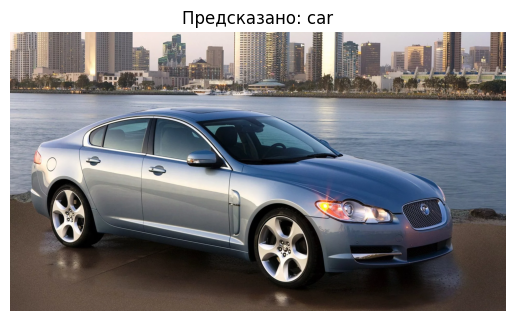

Файл: 2.jpeg


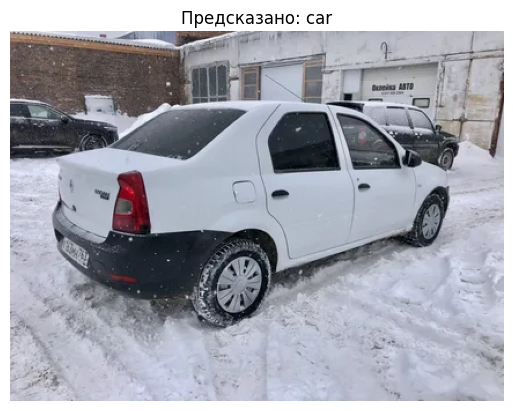

Файл: 3.jpeg


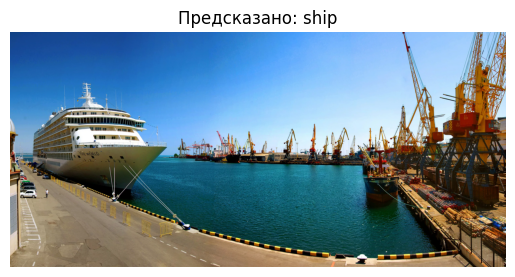

Файл: 4.jpeg


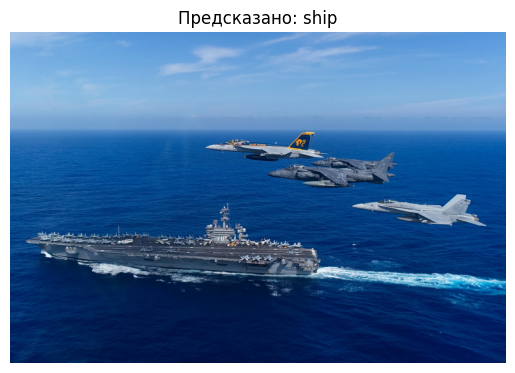

Файл: 5.jpg


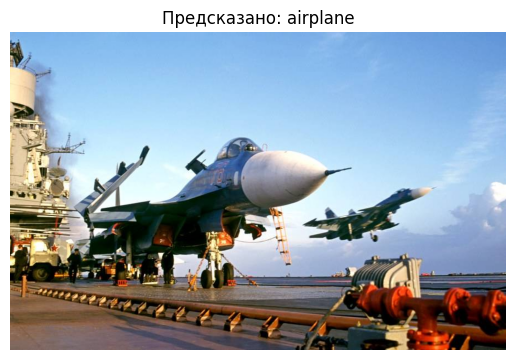

Файл: 6.jpg


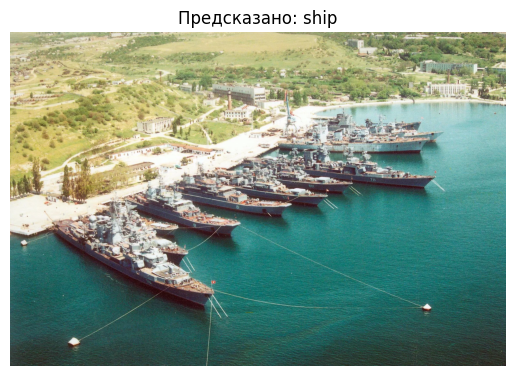

Файл: 7.jpg


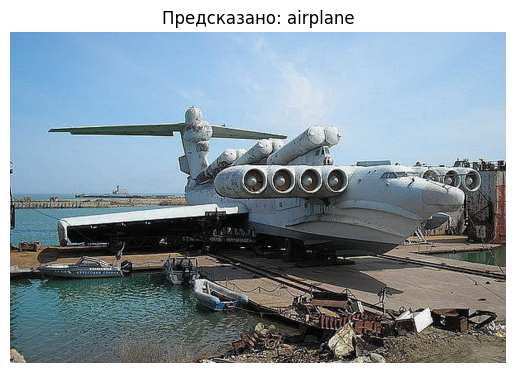

Файл: 8.jpg


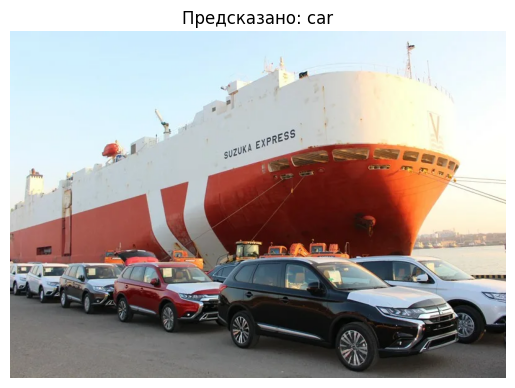

Файл: 9.jpeg


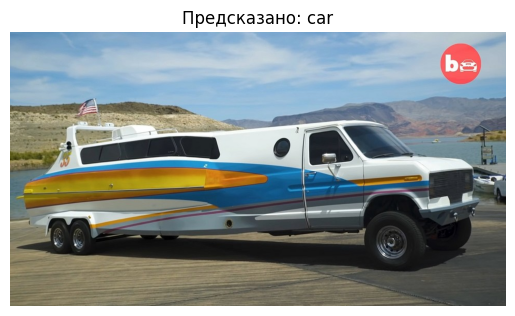

In [21]:
# Путь к сохранённой модели и пользовательским изображениям
model_path = "best_resnet_model.pth"
image_dir = "/content/drive/MyDrive/Colab Notebooks/CV_LAB4_DATA"

# Предобработка (та же, что при обучении)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Классы
class_names = ['airplane', 'car', 'ship']

# Загрузка модели
model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Функция для предсказания и вывода изображения
def predict_and_show(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # [1, C, H, W]

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_class = class_names[pred.item()]

    plt.imshow(image)
    plt.title(f'Предсказано: {predicted_class}')
    plt.axis('off')
    plt.show()

# Предсказание для всех изображений
for filename in os.listdir(image_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        print(f"Файл: {filename}")
        predict_and_show(os.path.join(image_dir, filename))